In [9]:
%reload_ext autoreload
%autoreload 2

In [ ]:
%pip install nltk
%pip install pick
%pip install pandas
%pip install wordcloud
%pip install spacy

In [ ]:
%pip install gensim==3.8.3

In [ ]:
%pip install pyLDAvis

In [1]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter


import numpy as np
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


import pandas as pd
from pandas import DataFrame
import seaborn as sns


from nltk.corpus import stopwords
from wordcloud import WordCloud
print(pd.__version__)

2.0.2


In [4]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amanu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [17]:
# combine all json file in all-weeks8-9
def slack_parser(path_channel):
    """ parse slack data to extract useful informations from the json file
        step of execution
        1. Import the required modules
        2. read all json file from the provided path
        3. combine all json files in the provided path
        4. extract all required informations from the slack data
        5. convert to dataframe and merge all
        6. reset the index and return dataframe
    """

    # specify path to get json files
    combined = []
    for json_file in glob.glob(f"{path_channel}*.json"):
        with open(json_file, 'r', encoding="utf8") as slack_data:
            combined.append(json.load(slack_data))

    # loop through all json files and extract required informations
    dflist = []
    for slack_data in combined:

        msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st, reply_users, \
        reply_count, reply_users_count, tm_thread_end = [],[],[],[],[],[],[],[],[],[]

        for row in slack_data:
            if 'bot_id' in row.keys():
                continue
            else:
                msg_type.append(row['type'])
                msg_content.append(row['text'])
                if 'user_profile' in row.keys(): sender_id.append(row['user_profile']['real_name'])
                else: sender_id.append('Not provided')
                time_msg.append(row['ts'])
                if row.get('blocks') and row['blocks'][0].get('elements') and row['blocks'][0]['elements'][0].get('elements'):
                    msg_dist.append(row['blocks'][0]['elements'][0]['elements'][0]['type'])
                else:
                    msg_dist.append('reshared')
                if 'thread_ts' in row.keys():
                    time_thread_st.append(row['thread_ts'])
                else:
                    time_thread_st.append(0)
                if 'reply_users' in row.keys(): reply_users.append(",".join(row['reply_users']))
                else:    reply_users.append(0)
                if 'reply_count' in row.keys():
                    reply_count.append(row['reply_count'])
                    reply_users_count.append(row['reply_users_count'])
                    tm_thread_end.append(row['latest_reply'])
                else:
                    reply_count.append(0)
                    reply_users_count.append(0)
                    tm_thread_end.append(0)
        data = zip(msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st,
         reply_count, reply_users_count, reply_users, tm_thread_end)
        columns = ['msg_type', 'msg_content', 'sender_name', 'msg_sent_time', 'msg_dist_type',
         'time_thread_start', 'reply_count', 'reply_users_count', 'reply_users', 'tm_thread_end']

        df = pd.DataFrame(data=data, columns=columns)
        df = df[df['sender_name'] != 'Not provided']
        dflist.append(df)

    dfall = pd.concat(dflist, ignore_index=True)
    dfall['channel'] = path_channel.split('/')[-2].split('.')[0]
    dfall = dfall.reset_index(drop=True)

    return dfall


def parse_slack_reaction(path, channel):
    """get reactions"""
    dfall_reaction = pd.DataFrame()
    combined = []
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)

    reaction_name, reaction_count, reaction_users, msg, user_id = [], [], [], [], []

    for k in combined:
        slack_data = json.load(open(k.name, 'r', encoding="utf-8"))

        for i_count, i in enumerate(slack_data):
            if 'reactions' in i.keys():
                for j in range(len(i['reactions'])):
                    msg.append(i['text'])
                    user_id.append(i['user'])
                    reaction_name.append(i['reactions'][j]['name'])
                    reaction_count.append(i['reactions'][j]['count'])
                    reaction_users.append(",".join(i['reactions'][j]['users']))

    data_reaction = zip(reaction_name, reaction_count, reaction_users, msg, user_id)
    columns_reaction = ['reaction_name', 'reaction_count', 'reaction_users_count', 'message', 'user_id']
    df_reaction = pd.DataFrame(data=data_reaction, columns=columns_reaction)
    df_reaction['channel'] = channel
    return df_reaction

def get_community_participation(path):
    """ specify path to get json files"""
    combined = []
    comm_dict = {}
    for json_file in glob.glob(f"{path}*.json"):
        with open(json_file, 'r') as slack_data:
            combined.append(slack_data)
    # print(f"Total json files is {len(combined)}")
    for i in combined:
        a = json.load(open(i.name, 'r', encoding='utf-8'))

        for msg in a:
            if 'replies' in msg.keys():
                for i in msg['replies']:
                    comm_dict[i['user']] = comm_dict.get(i['user'], 0)+1
    return comm_dict

In [18]:
def convert_2_timestamp(column, data):
    """convert from unix time to readable timestamp
        args: column: columns that needs to be converted to timestamp
                data: data that has the specified column
    """
    if column in data.columns.values:
        timestamp_ = []
        for time_unix in data[column]:
            if time_unix == 0:
                timestamp_.append(0)
            else:
                a = datetime.datetime.fromtimestamp(float(time_unix))
                timestamp_.append(a.strftime('%Y-%m-%d %H:%M:%S'))
        return timestamp_
    else: 
        print(f"{column} not in data")

def get_tagged_users(df):
    """get all @ in the messages"""

    return df['msg_content'].map(lambda x: re.findall(r'@U\w+', x))


    
def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
    """
    map slack_id to realnames
    user_profile: a dictionary that contains users info such as real_names
    comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
    """
    user_dict = {} # to store the id
    real_name = [] # to store the real name
    ac_comm_dict = {} # to store the mapping
    count = 0
    # collect all the real names
    for i in range(len(user_profile['profile'])):
        real_name.append(dict(user_profile['profile'])[i]['real_name'])

    # loop the slack ids
    for i in user_profile['id']:
        user_dict[i] = real_name[count]
        count += 1

    # to store mapping
    for i in comm_dict:
        if i in user_dict:
            ac_comm_dict[user_dict[i]] = comm_dict[i]

    ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
    columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
    if plot:
        ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
        plt.title('Student based on Message sent in thread', size=20)
        
    return ac_comm_dict

In [19]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

In [ ]:
# draw_wordcloud("the very first cbs is here", 11)

In [20]:
#Let's first create a data frame containing all the channels
def create_data_frame(root_directory) -> DataFrame:
    sl = SlackDataLoader(root_directory)
    channels = sl.get_channels()
    channel_names = [channels[i]['name'] for i in range(len(channels))]
    dfs = []

    for channel_name in channel_names:
        channel_path = root_directory + channel_name + '/'
        channel_df = slack_parser(channel_path)
        dfs.append(channel_df)

    all_data = pd.concat(dfs, ignore_index=True)
    return all_data

In [23]:
data_frame = create_data_frame('../data/anonymized/')

In [46]:
data_frame

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,message,"hi all, looking forward to starting together, ...",Lawrence Braun,1661094957.241139,text,0,0,0,0,0,all-community-building
1,message,hello everyone. it's my hope that you are doin...,Lynn Shepherd,1661151244.337329,text,0,0,0,0,0,all-community-building
2,message,*community building session reminder!*:timer_c...,Lynn Shepherd,1661169000.633059,text,1661169000.633059,3,2,"U03UG0YHAUT,U03V1AM5TFA",1661169624.405079,all-community-building
3,message,let's get ready to the first cbs of the progra...,David Nguyen,1661169461.106859,text,1661169000.633059,0,0,0,0,all-community-building
4,message,the very first cbs is here,Lynn Shepherd,1661169547.570659,text,1661169000.633059,0,0,0,0,all-community-building
...,...,...,...,...,...,...,...,...,...,...,...
17744,message,"<@u03tepyrm2p> so, do we unsubmit the assignm...",Tammy Foster,1668238555.900829,user,1668238555.900829,2,2,"U03TEPYRM2P,U03UJGP0C68",1668238742.488269,all-week12
17745,message,please use the submission link for week 12 to ...,Bridget Glover,1668238698.401879,text,1668238555.900829,0,0,0,0,all-week12
17746,message,"oh, ok thanks!",Tammy Foster,1668238742.488269,text,1668238555.900829,0,0,0,0,all-week12
17747,message,how can i get the trainees that opted-in a giv...,Dennis Parker,1668272023.894179,text,0,0,0,0,0,all-web3-week12


## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [39]:
# which user has the highest number of reply counts?
def find_highest_replied_user():
    sorted_df = data_frame.sort_values("reply_count", ascending=False)
    return sorted_df.iloc[0]["sender_name"]


In [40]:
print(find_highest_replied_user())

Kenneth Williams


In [49]:
# Visualize reply counts per user per channel
def reply_per_user_per_channel(data: DataFrame):
    grouped_df = data.groupby(['channel', 'sender_name'])['reply_count'].sum().unstack()
    grouped_df.plot(kind='bar', figsize=(15, 7.5), stacked=True)

    plt.title('Reply Counts per User per Channel')
    plt.xlabel('Channel')
    plt.ylabel('Total Reply Count')
    plt.legend(title='Sender Name', bbox_to_anchor=(1, 1))
    plt.show()


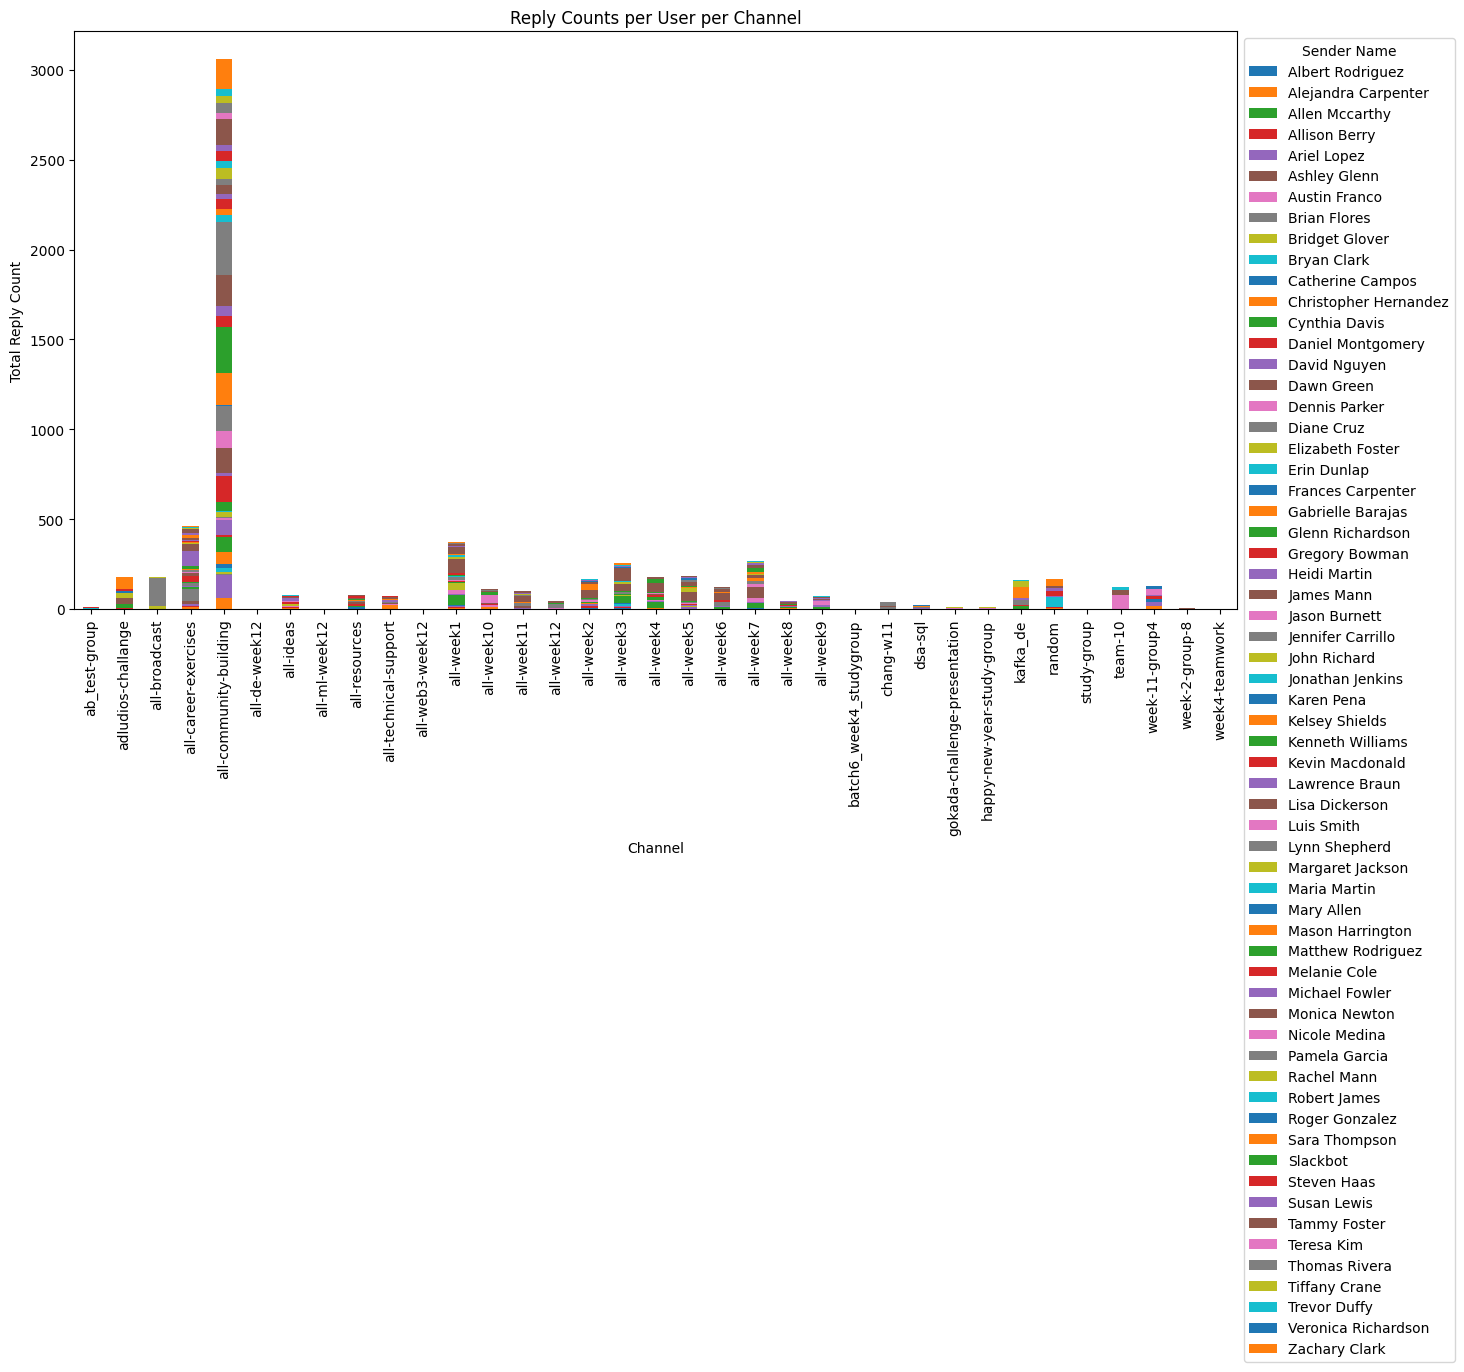

In [48]:
reply_per_user_per_channel(data_frame)

In [54]:
#plot of highest number of reply counts per user

def plot_highest_replies_per_user(data: DataFrame):
    grouped_df = data.groupby('sender_name')['reply_count'].sum()
    grouped_df = grouped_df.sort_values()
    grouped_df.plot(kind='bar', figsize=(13, 8))
    plt.title('Reply Counts of users')
    plt.xlabel('User')
    plt.ylabel('Number of replies')
    plt.show()

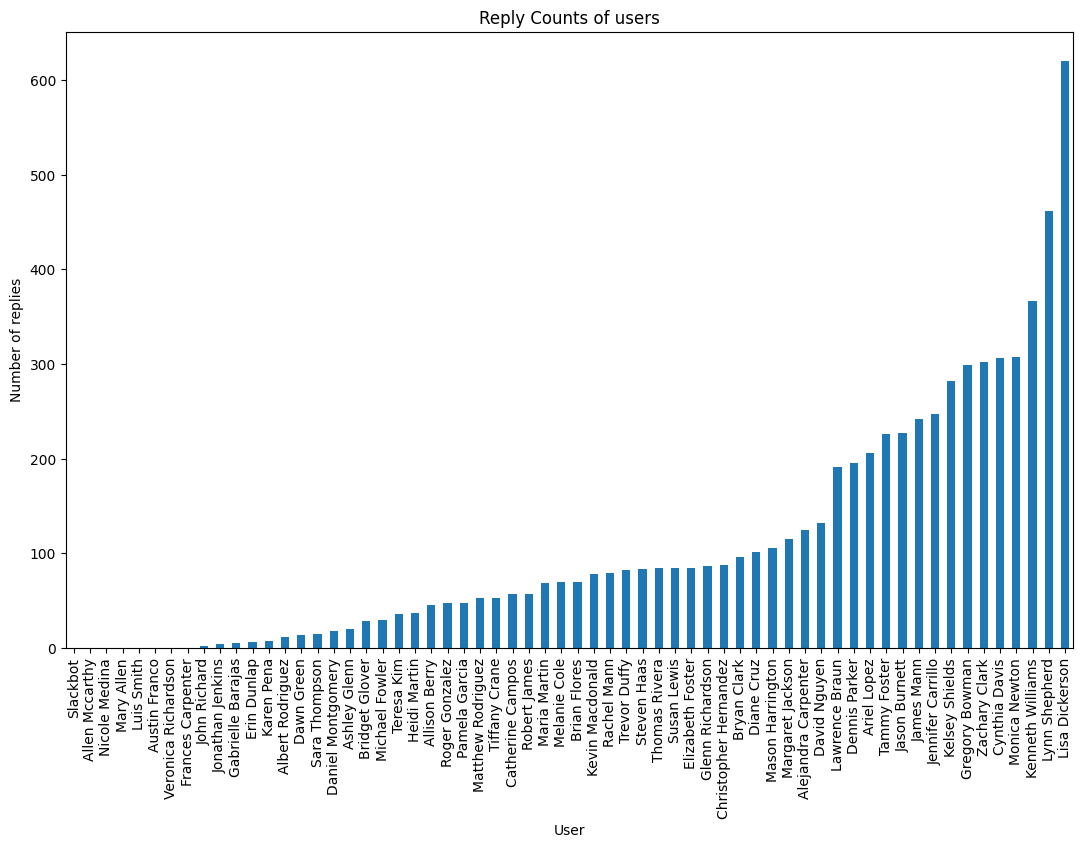

In [55]:
plot_highest_replies_per_user(data_frame)

In [56]:
#users with highest message count
def top_ten_users_with_many_messages(data: DataFrame):
    counts = data.groupby('sender_name').size()
    top_users = counts.sort_values(ascending=False).head(10)
    return top_users

In [57]:
users_with_many_messages(data_frame)

sender_name
Lynn Shepherd        1288
Kelsey Shields       1150
Gregory Bowman       1075
Zachary Clark         991
Monica Newton         843
Lisa Dickerson        831
Ariel Lopez           754
James Mann            641
Tammy Foster          574
Jennifer Carrillo     519
dtype: int64

In [58]:
def bottom_ten_users_with_many_messages(data: DataFrame):
    counts = data.groupby('sender_name').size()
    top_users = counts.sort_values(ascending=False).head(10)
    return top_users

In [59]:
bottom_ten_users_with_many_messages(data_frame)

sender_name
Lynn Shepherd        1288
Kelsey Shields       1150
Gregory Bowman       1075
Zachary Clark         991
Monica Newton         843
Lisa Dickerson        831
Ariel Lopez           754
James Mann            641
Tammy Foster          574
Jennifer Carrillo     519
dtype: int64

In [61]:
#Top 10 messages with many replies
def message_with_replies(data: DataFrame):
    df = data.sort_values(by='reply_count', ascending=False)
    return df

In [62]:
message_with_replies(data_frame).head(10)

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
7433,message,<@u03v1am5tfa> how many crushes you have?,Kenneth Williams,1668169350.223689,user,1668169350.223689,75,8,"U03V1AM5TFA,U03UUS0MZCZ,U03UG32J3PC,U03UVHCV6K...",1668173595.550369,all-community-building
2154,message,first impression: people think i am older than...,Kevin Macdonald,1663072090.617319,text,1663072090.617319,63,8,"U03UUR571A5,U03UG32J3PC,U03UFV7TUTV,U03V785NLS...",1663077515.282329,all-community-building
15141,message,1. how do i find my jupyter notebook file in m...,James Mann,1664916746.043439,rich_text_section,1664916746.043439,61,5,"U03UUR571A5,U03UVHCV6KB,U03U9EJR362,U03UD68RQH...",1664920378.724399,all-week7
6184,message,how many here follow football so much? i think...,Kenneth Williams,1666700374.650289,text,1666700374.650289,57,10,"U03V5Q9N516,U03V785NLSU,U03UG32J3PC,U03UJN29Y4...",1666709362.373899,all-community-building
10014,message,ethiopian new year loading ....,Bryan Clark,1662400744.293029,text,1662400744.293029,54,3,"U03UG32J3PC,U03UUR571A5,U03UFV7TUTV",1662406508.168569,random
11796,message,hello\n1. <@u03uvhcv6kb>\n2. <@u03ug5vfn03>\n3...,Lynn Shepherd,1667286619.471889,text,1667286619.471889,45,7,"U03UG32J3PC,U03UG0SFHGT,U03UG5VFN03,U03V1AM5TF...",1667308401.183059,all-broadcast
16480,message,<@u03uur571a5> solutions to funding account an...,Jason Burnett,1666858629.076399,user,1666858629.076399,44,4,"U03UUR571A5,U03UJGP0C68,U03U1FNPEUX,U03UKL27B0R",1666944753.417749,all-week10
10465,message,we had a plan to meet today 2:00 eat at friend...,Zachary Clark,1667700160.574059,text,1667700160.574059,36,4,"U03UG32J3PC,U03UUR571A5,U03UD68RQH3,U03UG0YHAUT",1667713572.552719,random
11627,message,*<!here> reminder*:timer_clock:\n\n*please not...,Lynn Shepherd,1665137100.215739,broadcast,1665137100.215739,33,3,"U03UH397319,U03TEPYRM2P,U03V1AM5TFA",1665142057.729989,all-broadcast
4198,message,"the debate was great. we <@u03u1j51vfz>, <@u03...",Kenneth Williams,1665057691.571429,text,1665057691.571429,31,12,"U03UUR571A5,U03U1J51VFZ,U03UD68RQH3,U03UJN29Y4...",1665059196.765399,all-community-building


In [ ]:
#Bottom 10 messages with many replies
def message_with_replies(data: DataFrame):
    df = data.sort_values(by='reply_count', ascending=False)
    return df

In [63]:
message_with_replies(data_frame).tail(10)

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
6275,message,<@u03ujkjgraq> yea what is the issue??,Kelsey Shields,1666701935.090889,user,1666700374.650289,0,0,0,0,all-community-building
6276,message,i hope both of you will work in the same compa...,Robert James,1666702060.917029,text,1666701040.604379,0,0,0,0,all-community-building
6277,message,i am gonna watch every recording and get to th...,Kelsey Shields,1666702061.270639,text,1666701203.277889,0,0,0,0,all-community-building
6278,message,:joy:,Monica Newton,1666702101.748279,emoji,1666701203.277889,0,0,0,0,all-community-building
6279,message,"let me confess, i am the one :pensive:",Zachary Clark,1666702110.327479,text,1666701203.277889,0,0,0,0,all-community-building
6280,message,i second that.:rolling_on_the_floor_laughing:,Kelsey Shields,1666702124.806239,text,1666701203.277889,0,0,0,0,all-community-building
6281,message,i think <@u03ujkjgraq> is taking a very very s...,Gregory Bowman,1666702145.297929,text,1666700374.650289,0,0,0,0,all-community-building
6282,message,<@u03v785nlsu> fans care way too much about it...,Kenneth Williams,1666702165.461119,user,1666700374.650289,0,0,0,0,all-community-building
6283,message,:rolling_on_the_floor_laughing: confessions ha...,Monica Newton,1666702181.813739,emoji,1666701203.277889,0,0,0,0,all-community-building
17748,message,<https://developer.algorand.org/solutions/mint...,Dennis Parker,1668359175.400459,link,0,0,0,0,0,all-web3-week12


In [66]:
#create a data frame for reactions
def create_reaction_data_frame():
    sl = SlackDataLoader()
    channels = sl.get_channels()
    channel_names = [channels[i]['name'] for i in range(len(channels))]
    reaction_data_frames = []

    for name in channel_names:
        channel_path = '../data/anonymized/' + name + '/'
        channel_dataframe = parse_slack_reaction(channel_path, name)
        reaction_data_frames.append(channel_dataframe)

    all_data = pd.concat(reaction_data_frames, ignore_index=True)
    return all_data

In [67]:
reaction_df = create_reaction_data_frame()
reaction_df

,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
0,+1,12,"U03UFV7TUTV,U03U1HAG9TR,U03UFV7HFNF,U03U9EJR36...","hi all, looking forward to starting together, ...",U03U93GNNVB,all-community-building
1,muscle,2,"U03UG0YHAUT,U03UUR571A5","hi all, looking forward to starting together, ...",U03U93GNNVB,all-community-building
2,heart,2,"U03UUMM7Y8H,U03UD68RQH3","hi all, looking forward to starting together, ...",U03U93GNNVB,all-community-building
3,+1,8,"U03UFV7HFNF,U03UG4Q7V42,U03U9EJR362,U03U1J51VF...",hello everyone. it's my hope that you are doin...,U03V1AM5TFA,all-community-building
4,clap,2,"U03U1HAG9TR,U03UG0YHAUT",hello everyone. it's my hope that you are doin...,U03V1AM5TFA,all-community-building
...,...,...,...,...,...,...
5012,pray,1,U03UFV7HFNF,working now.,U03UP7V9Q57,all-week12
5013,heavy_check_mark,2,"U03U1FNPEUX,U03U9EJR362",<https://www.linkedin.com/feed/update/urn:li:a...,U03UG0YHAUT,all-week12
5014,raised_hands,1,U03UG5VFN03,etl and elt,U03UHB8CXDY,all-week12
5015,white_check_mark,1,U03UJGP0C68,please use the submission link for week 12 to ...,U03TEPYRM2P,all-week12


In [68]:
#Top 10 users with highest reaction counts
def users_with_highest_reactions(data: DataFrame):
    users = data.sort_values('reaction_count', ascending=False).head(10)
    return users

In [69]:
users_with_highest_reactions(reaction_df)

,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
4675,white_check_mark,17,"U03UG5VFN03,U03UJGP0C68,U03V785NLSU,U03UG0YHAU...","good morning winners, welcome to week 9 of wee...",U03TEPYRM2P,all-week9
748,raised_hands,16,"U03UD68RQH3,U03U9EJR362,U03UFV7TUTV,U03U1FNPEU...",,U03U1GHT39V,all-community-building
4070,raised_hands,16,"U03U1GHT39V,U03UJN29Y4C,U03UG1RTXAP,U03UG4Q7V4...",little known fact - all Joanne academy technic...,U03U93GNNVB,all-broadcast
983,joy,16,"U03UUR571A5,U03V785NLSU,U03UD68RQH3,U03UD4FEDH...",my reactions when am not finished the task bef...,U03UG0SFHGT,all-community-building
1227,rolling_on_the_floor_laughing,15,"U03UG32J3PC,U03U9EJR362,U03U1HAG9TR,U03UJGP0C6...",*guys <!here>.... make sure to come back from ...,U03V1AM5TFA,all-community-building
1133,joy,15,"U03V6HMRPGQ,U03U9EJR362,U03UFV7HFNF,U03UVHCV6K...",*here are some other stories from people that ...,U03V1AM5TFA,all-community-building
4468,raised_hands,15,"U03UG32J3PC,U03V61VGQG0,U03UG0YHAUT,U03UJGRN5E...","welcome to week6 everyone. by friday, we’ll be...",U03TEPYRM2P,all-week6
3393,raised_hands,14,"U03UJGP0C68,U03UG32J3PC,U03UG0SFHGT,U03UG1Z21J...",<!channel>\nthere will be no careers exercise ...,U03TT5KEYCF,all-career-exercises
2813,rolling_on_the_floor_laughing,14,"U03UJGP0C68,U03UG4Q7V42,U03UFV7HFNF,U03UG1Z21J...","1- let me open my vpn, where do you want me to...",U03V6HMRPGQ,all-community-building
2541,fire,13,"U03UJGP0C68,U03UJGRN5E0,U03UG1Z21JP,U03U9EJR36...",*hot seat announcement! <!here>*\n_*good morni...,U03V1AM5TFA,all-community-building


In [71]:
#Bottom 10 users with highest reaction counts
def users_with_lowest_reactions(data: DataFrame):
    users = data.sort_values('reaction_count', ascending=False).tail(10)
    return users

In [72]:
users_with_lowest_reactions(reaction_df)

,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
2610,raised_hands,1,U03V1AM5TFA,my life would be is not much like but i want i...,U03UG0YHAUT,all-community-building
2611,grinning,1,U03UFV7HFNF,friends :joy: just a series.,U03U9EJR362,all-community-building
2614,grinning,1,U03UFV7HFNF,you can be jesse lol:sweat_smile:,U03U1FNPEUX,all-community-building
531,pray,1,U03UFV7HFNF,wow hbd!!,U03UD4FEDHB,all-community-building
530,pray,1,U03UFV7HFNF,happy birth day two of you brothers,U03UGB3T3MY,all-community-building
2621,+1,1,U03U1HAG9TR,i like to hear motivational speech rather than...,U03UG5VFN03,all-community-building
2623,100,1,U03U1HAG9TR,i would be army of the dead rescue to protect ...,U03UG0SFHGT,all-community-building
529,pray,1,U03UFV7HFNF,happy birth day for both of you,U03UG5VFN03,all-community-building
2627,heart,1,U03V6HMRPGQ,this is a x-mas celebration in lalibela.,U03UG32J3PC,all-community-building
5016,raised_hands,1,U03UVHCV6KB,<@u03ul5lstg9> has joined the channel,U03UL5LSTG9,data-engineering


In [73]:
#Top 10 messages with highest reactions
def message_with_highest_reactions(data: DataFrame):
    messages = data.sort_values("reaction_count", ascending = False).head(10)
    return messages

In [74]:
message_with_highest_reactions(reaction_df)

,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
4675,white_check_mark,17,"U03UG5VFN03,U03UJGP0C68,U03V785NLSU,U03UG0YHAU...","good morning winners, welcome to week 9 of wee...",U03TEPYRM2P,all-week9
748,raised_hands,16,"U03UD68RQH3,U03U9EJR362,U03UFV7TUTV,U03U1FNPEU...",,U03U1GHT39V,all-community-building
4070,raised_hands,16,"U03U1GHT39V,U03UJN29Y4C,U03UG1RTXAP,U03UG4Q7V4...",little known fact - all Joanne academy technic...,U03U93GNNVB,all-broadcast
983,joy,16,"U03UUR571A5,U03V785NLSU,U03UD68RQH3,U03UD4FEDH...",my reactions when am not finished the task bef...,U03UG0SFHGT,all-community-building
1227,rolling_on_the_floor_laughing,15,"U03UG32J3PC,U03U9EJR362,U03U1HAG9TR,U03UJGP0C6...",*guys <!here>.... make sure to come back from ...,U03V1AM5TFA,all-community-building
1133,joy,15,"U03V6HMRPGQ,U03U9EJR362,U03UFV7HFNF,U03UVHCV6K...",*here are some other stories from people that ...,U03V1AM5TFA,all-community-building
4468,raised_hands,15,"U03UG32J3PC,U03V61VGQG0,U03UG0YHAUT,U03UJGRN5E...","welcome to week6 everyone. by friday, we’ll be...",U03TEPYRM2P,all-week6
3393,raised_hands,14,"U03UJGP0C68,U03UG32J3PC,U03UG0SFHGT,U03UG1Z21J...",<!channel>\nthere will be no careers exercise ...,U03TT5KEYCF,all-career-exercises
2813,rolling_on_the_floor_laughing,14,"U03UJGP0C68,U03UG4Q7V42,U03UFV7HFNF,U03UG1Z21J...","1- let me open my vpn, where do you want me to...",U03V6HMRPGQ,all-community-building
2541,fire,13,"U03UJGP0C68,U03UJGRN5E0,U03UG1Z21JP,U03U9EJR36...",*hot seat announcement! <!here>*\n_*good morni...,U03V1AM5TFA,all-community-building


In [75]:
#Bottom 10 messages with highest reactions
def message_with_lowest_reactions(data: DataFrame):
    messages = data.sort_values("reaction_count", ascending = False).tail(10)
    return messages

In [76]:
message_with_lowest_reactions(reaction_df)

,reaction_name,reaction_count,reaction_users_count,message,user_id,channel
2610,raised_hands,1,U03V1AM5TFA,my life would be is not much like but i want i...,U03UG0YHAUT,all-community-building
2611,grinning,1,U03UFV7HFNF,friends :joy: just a series.,U03U9EJR362,all-community-building
2614,grinning,1,U03UFV7HFNF,you can be jesse lol:sweat_smile:,U03U1FNPEUX,all-community-building
531,pray,1,U03UFV7HFNF,wow hbd!!,U03UD4FEDHB,all-community-building
530,pray,1,U03UFV7HFNF,happy birth day two of you brothers,U03UGB3T3MY,all-community-building
2621,+1,1,U03U1HAG9TR,i like to hear motivational speech rather than...,U03UG5VFN03,all-community-building
2623,100,1,U03U1HAG9TR,i would be army of the dead rescue to protect ...,U03UG0SFHGT,all-community-building
529,pray,1,U03UFV7HFNF,happy birth day for both of you,U03UG5VFN03,all-community-building
2627,heart,1,U03V6HMRPGQ,this is a x-mas celebration in lalibela.,U03UG32J3PC,all-community-building
5016,raised_hands,1,U03UVHCV6KB,<@u03ul5lstg9> has joined the channel,U03UL5LSTG9,data-engineering


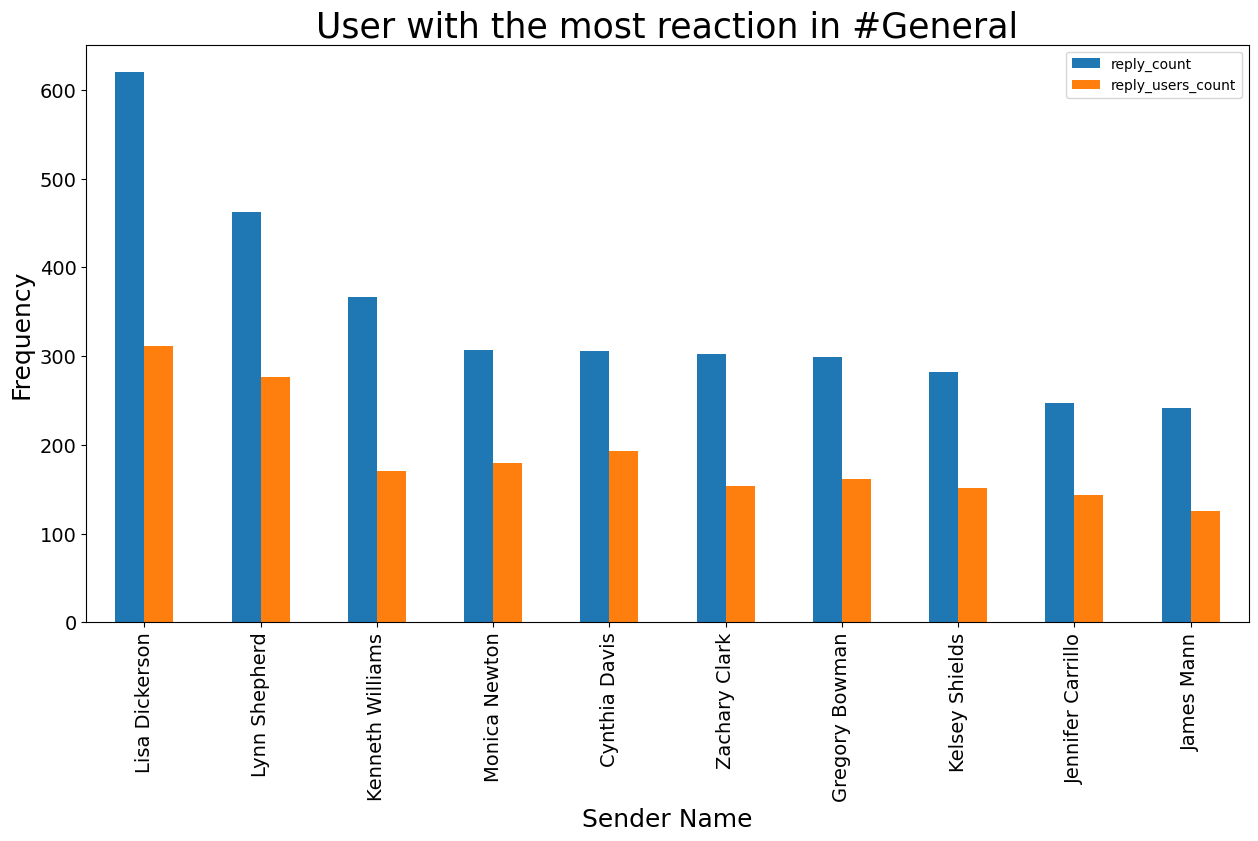

In [78]:
draw_user_reaction(data_frame)

In [ ]:
# what is the time range of the day that most messages are sent?


In [ ]:
# what kind of messages are replied faster than others?

In [ ]:
# Relationship between # of messages and # of reactions

In [ ]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [ ]:
# Which users got the most reactions?

In [ ]:
# Model topics mentioned in the channel

In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?

## Topic Modeling and Sentiment analysis

In [14]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [25]:
data_frame.columns

Index(['msg_type', 'msg_content', 'sender_name', 'msg_sent_time',
       'msg_dist_type', 'time_thread_start', 'reply_count',
       'reply_users_count', 'reply_users', 'tm_thread_end', 'channel'],
      dtype='object')

In [ ]:
data = data_frame.msg_content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:5])

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

In [30]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [36]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm')

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['looking_forward', 'start', 'together', 'tomorrow']]


In [37]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [38]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [39]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.166*"say" + 0.163*"today" + 0.151*"connect" + 0.144*"code" + '
  '0.097*"change" + 0.045*"choose" + 0.033*"explain" + 0.027*"activity" + '
  '0.000*"hugging_face" + 0.000*"favorite"'),
 (1,
  '0.217*"submission" + 0.120*"miss" + 0.061*"due" + 0.024*"big" + '
  '0.000*"submit" + 0.000*"video" + 0.000*"document" + 0.000*"yet" + '
  '0.000*"guy" + 0.000*"upload"'),
 (2,
  '0.180*"face" + 0.170*"send" + 0.134*"link" + 0.133*"want" + 0.118*"end" + '
  '0.024*"light" + 0.020*"bro" + 0.016*"feel" + 0.011*"joanne_academy" + '
  '0.007*"alone"'),
 (3,
  '0.570*"work" + 0.185*"task" + 0.033*"report" + 0.024*"finish" + '
  '0.022*"reach" + 0.008*"goal" + 0.007*"hard" + 0.000*"social" + 0.000*"try" '
  '+ 0.000*"think"'),
 (4,
  '0.311*"problem" + 0.173*"result" + 0.150*"tutorial" + 0.000*"image" + '
  '0.000*"template" + 0.000*"cv" + 0.000*"model" + 0.000*"solve" + '
  '0.000*"startx" + 0.000*"gray"'),
 (5,
  '0.264*"last" + 0.199*"give" + 0.073*"day" + 0.071*"manage" + 0.058*"man" + '


In [40]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -22.649976030918634

Coherence Score:  0.34241776531391654


In [41]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11     0.174177  0.242549       1        1  9.298429
17     0.088356  0.028901       2        1  8.527926
18    -0.048153 -0.008748       3        1  8.507217
19     0.131155  0.072728       4        1  7.503427
3      0.238355 -0.314302       5        1  7.194331
0      0.124388  0.062111       6        1  6.348928
14    -0.083366 -0.011725       7        1  6.134783
2      0.096658  0.034945       8        1  5.710552
9      0.003481 -0.001010       9        1  4.635226
7     -0.014438 -0.004220      10        1  4.527529
13    -0.078703 -0.011466      11        1  4.443647
12     0.000349 -0.001608      12        1  4.432490
5     -0.048623 -0.008862      13        1  4.429507
8     -0.054237 -0.009475      14        1  3.834608
16    -0.079632 -0.011493      15        1  3.570131
6     -0.092431 -0.012042      16        1  3.519430
15    -0.080111 -0.011514      17        1  2.755493
4     -0.076198 -0.011268      18        1  2.041586
1     -0.098823 -0.011939      19        1  1.349873
10    -0.102205 -0.011561      20        1  1.234888, topic_info=              Term         Freq        Total Category  logprob  loglift
110            com  4301.000000  4301.000000  Default  30.0000  30.0000
167           work  3357.000000  3357.000000  Default  29.0000  29.0000
133          datum  2284.000000  2284.000000  Default  28.0000  28.0000
17             use  2333.000000  2333.000000  Default  27.0000  27.0000
27             get  2348.000000  2348.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
3226      instance     0.096837     2.817802  Topic20  -9.2530   1.0235
557            try     0.096834     2.818378  Topic20  -9.2531   1.0233
3915  presentation     0.096824     2.814316  Topic20  -9.2532   1.0246
289        standup     0.096824     2.814450  Topic20  -9.2532   1.0246
1516           yet     0.096823     2.814477  Topic20  -9.2532   1.0245

[832 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
256      14  0.994032      able
114       6  0.979658  activity
239      13  0.974064    almost
267       8  0.929974     alone
101      14  0.990815   already
...     ...       ...       ...
53        1  0.997892      week
251      17  0.995715      well
214       4  0.802409      wink
167       5  0.999205      work
113       3  0.993649   youtube

[127 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 18, 19, 20, 4, 1, 15, 3, 10, 8, 14, 13, 6, 9, 17, 7, 16, 5, 2, 11])

In [48]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values